# Step 2: Model Calibration and Testing

This model uses VAR (Vector Auto Regressive) method to estimate CPR (CPI return). It also uses GEE (Generalized Estimating Equation) to take into account correlation since each time T has 10 prices and they're correlated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
cities_cbsa = [12060, 14460, 16980, 19100, 26420, 31080, 33100, 35620, 37980, 47900]

In [3]:
cpi = pd.read_csv('cpi_final.csv', index_col='period', parse_dates = True)
cpr = pd.read_csv('cpr_final.csv', index_col='period', parse_dates = True)
mean_all = pd.read_csv('mean_all.csv')
dist_all = pd.read_csv('dist_all.csv')

In [4]:
cpr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cbsa,480.0,27470.000000,11088.217298,12060.000000,16980.000000,28750.000000,35620.000000,47900.000000
ret,480.0,-0.018687,0.202388,-0.703909,-0.101883,0.004099,0.111199,0.475699
mortgage30us,480.0,-0.093392,0.270243,-0.467211,-0.302198,-0.173126,0.199300,0.434324
mortgage30us_l1,480.0,-0.084313,0.269579,-0.467211,-0.297892,-0.157963,0.199300,0.434324
mortgage30us_l2,480.0,-0.073963,0.272116,-0.467211,-0.297892,-0.150475,0.216990,0.434324
mortgage30us_chg,480.0,0.008708,0.195707,-0.516035,-0.123511,-0.030176,0.133432,0.483965
mortgage30us_chg_l1,480.0,0.006098,0.198051,-0.516035,-0.125625,-0.030176,0.133432,0.483965
mortgage30us_chg_l2,480.0,0.010238,0.198954,-0.516035,-0.125625,-0.014417,0.142945,0.483965
return_l1,480.0,-0.015818,0.204392,-0.703909,-0.101883,0.008345,0.113015,0.475699
return_l2,480.0,-0.014573,0.204748,-0.703909,-0.101883,0.011754,0.116365,0.475699


In [5]:
cpr['intercept'] = 1

cpr.reset_index(inplace=True)

## Variable Selection Process

This is a state-of-the-art. It has been going through multiple iterations. Note that I've implemented GEE after writing all the following programs and some variables are no longer significant. Unfortunately I don't have enough time to modify it. This is a room for improvements.

## Final Variables

In [8]:
selected_vars = ['intercept','mortgage30us_l1','mortgage30us_chg_l1',
               'return_l1', 'pop_gr_l1']

y = cpr['ret']
X = cpr[selected_vars]

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/preeda/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
ex = sm.cov_struct.Exchangeable()
model1 = sm.GEE.from_formula("ret ~ mortgage30us_l1 + mortgage30us_chg_l1 + return_l1 + pop_gr_l1",
                             groups="period", data=cpr, cov_struct=ex)
result = model1.fit()
print(result.summary())

                               GEE Regression Results                              
Dep. Variable:                         ret   No. Observations:                  480
Model:                                 GEE   No. clusters:                       48
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:         Exchangeable   Num. iterations:                    13
Date:                     Fri, 15 Nov 2019   Scale:                           0.014
Covariance type:                    robust   Time:                         21:17:29
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0212      0.015     -1.402      0.161     

Variable Selection Criteria:
- Intuitive Sign: Lower mortgage rate leads to higher price. Increasing rate means we're in a benign period. Return lag 1 shows a momentum. Population Growth lag 1 means the increase in population growth leads to a higher prices.
- P-value should be lower than 0.05 but 0.10 can be acceptable.

pop_gr_l1 = Population growth lag 1 and mortgage30us_chg_l1 = Morgage rate change lag 1 are not significant at 0.05 but we'll move forward with this.

In [12]:
print(ex.summary())

The correlation between two observations in the same cluster is 0.439


Correlation of two prices in the same period is 43.9%

In [13]:
cpr['normreturn_pred'] = result.predict(X)

In [14]:
cpi.reset_index(inplace=True)

cpi = cpi.merge(cpr, how='left', left_on=['period','cbsa'], right_on=['period','cbsa'])
cpi = cpi.merge(mean_all, how='left', left_on=['cbsa'], right_on=['cbsa'])
cpi = cpi.merge(dist_all, how='left', left_on=['cbsa'], right_on=['cbsa'])

mean_col = [col for col in cpi if col.startswith('mean')]
dist_col = [col for col in cpi if col.startswith('dist')]

In [16]:
cpr_normpred = cpi.pivot(index='period', columns='cbsa', values='normreturn_pred')
mean_cpr = cpi.pivot(index='period', columns='cbsa', values='mean_cpr')
dist_cpr = cpi.pivot(index='period', columns='cbsa', values='dist_cpr')
cpi_actual = cpi.pivot(index='period', columns='cbsa', values='cpi')

In [17]:
cpr_pred = (cpr_normpred * dist_cpr) + mean_cpr
cpi_pred = cpi_actual.shift(1) * (1 + cpr_pred)

In [18]:
def w_to_l(df,id1,col1,col2):
    df.reset_index(inplace=True)
    df = pd.melt(df, id_vars=[id1],value_vars=df.columns[1:])
    df.columns = [id1,col1,col2]
    df[col1] = pd.to_numeric(df[col1])
    return df

In [19]:
cpr_pred_long = w_to_l(cpr_pred,'period','cbsa','return_pred')
cpi_pred_long = w_to_l(cpi_pred,'period','cbsa','cpi_pred')

## Combine

In [20]:
cpi.reset_index(inplace=True)
cpr_pred
cpi = cpi.merge(cpr_pred_long, how='left', left_on=['period','cbsa'], right_on=['period','cbsa'])
cpi = cpi.merge(cpi_pred_long, how='left', left_on=['period','cbsa'], right_on=['period','cbsa'])

# Performance Metrics

In [21]:
print("Correlation = ", cpi[['return_pred','ret']].corr().iloc[0][1])

Correlation =  0.811684493956


## Correlation by Zip

In [23]:
print(cpi.groupby('cbsa')[['return_pred','ret']].corr().iloc[0::2,-1])

cbsa              
12060  return_pred    0.822272
14460  return_pred    0.836695
16980  return_pred    0.840452
19100  return_pred    0.808352
26420  return_pred    0.795886
31080  return_pred    0.894359
33100  return_pred    0.799784
35620  return_pred    0.861514
37980  return_pred    0.862149
47900  return_pred    0.815946
Name: ret, dtype: float64


## Correlation by Year
This is a room for improvements as well. More variables should be investigated. Note that the calculation is from a small sample size (4 qtrs * 10 areas = 40 data points).

In [24]:
cpi.set_index(['period'], inplace=True)
cpi['year'] = cpi.index.year

In [25]:
print(cpi.groupby('year')[['return_pred','ret']].corr().iloc[0::2,-1])

year             
2001  return_pred         NaN
2002  return_pred         NaN
2003  return_pred         NaN
2004  return_pred         NaN
2005  return_pred    0.157237
2006  return_pred   -0.081824
2007  return_pred   -0.184663
2008  return_pred    0.463324
2009  return_pred    0.135497
2010  return_pred    0.568767
2011  return_pred    0.595686
2012  return_pred    0.269459
2013  return_pred    0.608493
2014  return_pred    0.264470
2015  return_pred    0.224623
2016  return_pred    0.528914
2017  return_pred    0.600195
Name: ret, dtype: float64


# Back-testing Chart

In [26]:
cpi.reset_index(inplace=True)
cpi_short = cpi[['period','cbsa','cpi','cpi_pred']]
cpi_short.set_index(['period'], inplace=True)
cpi_short = cpi_short[str(cpr.period.min()):]

In [27]:
cpi_short.reset_index(inplace=True)

In [28]:
df = pd.DataFrame()
df = cpi_short.pivot(index='period', columns='cbsa', values='cpi')
df_est = cpi_short.pivot(index='period', columns='cbsa', values='cpi_pred')

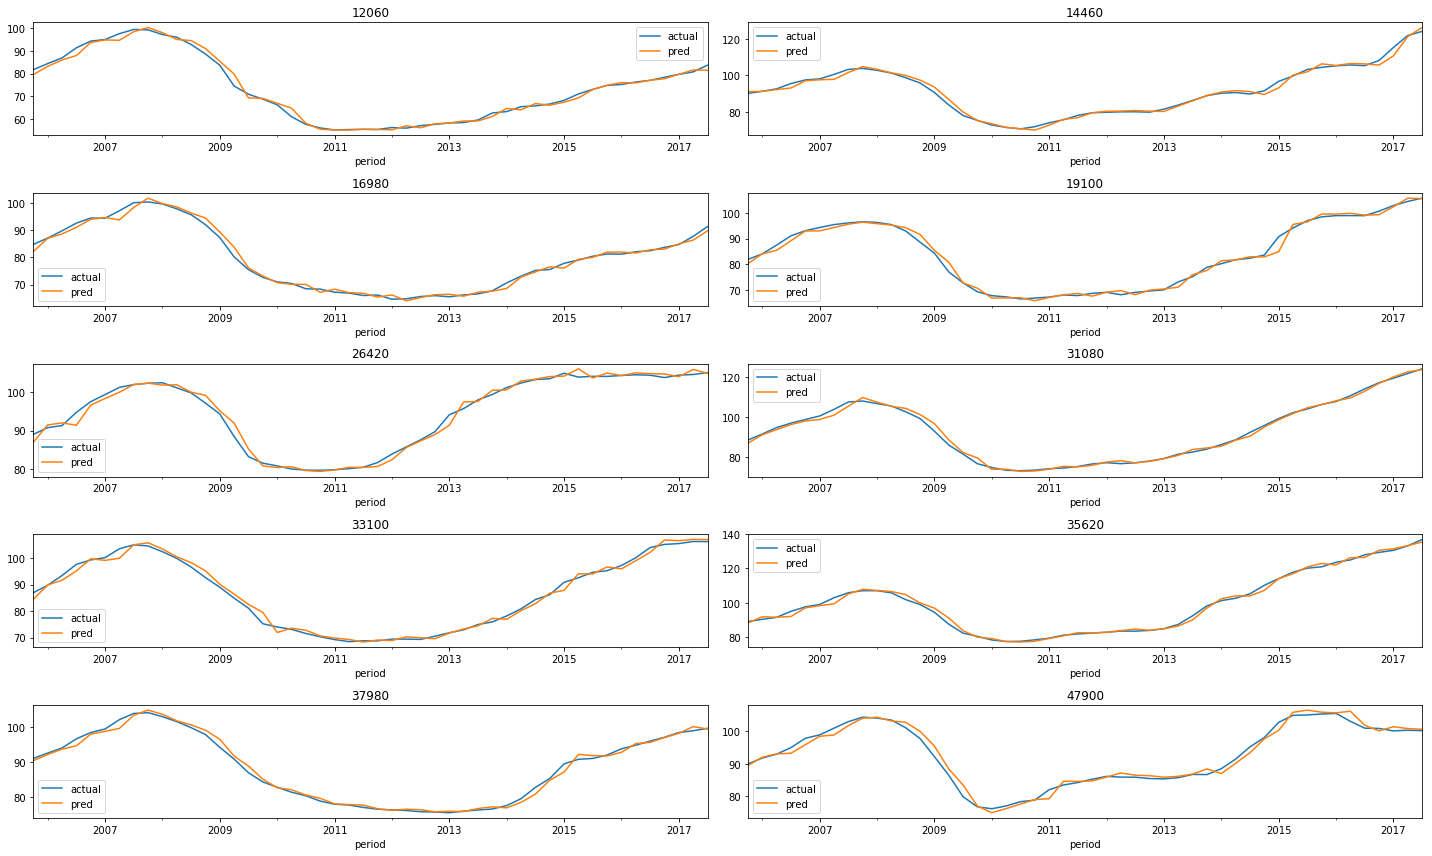

In [29]:
nrow=5
ncol=2
# make a list of all dataframes 
df_list = [df[cities_cbsa[0]] ,df[cities_cbsa[1]], df[cities_cbsa[2]], df[cities_cbsa[3]],df[cities_cbsa[4]],
           df[cities_cbsa[5]] ,df[cities_cbsa[6]], df[cities_cbsa[7]], df[cities_cbsa[8]],df[cities_cbsa[9]]]
df_est_list = [df_est[cities_cbsa[0]] ,df_est[cities_cbsa[1]], df_est[cities_cbsa[2]], df_est[cities_cbsa[3]], df_est[cities_cbsa[4]],
           df_est[cities_cbsa[5]] ,df_est[cities_cbsa[6]], df_est[cities_cbsa[7]], df_est[cities_cbsa[8]], df_est[cities_cbsa[9]]]

fig, axes = plt.subplots(nrow, ncol)
fig.set_size_inches(20, 12)

# plot counter
count=0
i=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], title=cities_cbsa[i], label='actual', legend=True)
        df_est_list[count].plot(ax=axes[r,c], label='pred', legend=True)
        count+=1
        i+=1
fig.tight_layout()

# Save model results

In [30]:
result.save("cadre_model.pickle")

In [31]:
cpi.to_csv('cadre_cpi.csv', index=None)